In [ ]:
import pandas as pd

# Function to clean the ground truth files
def clean_ground_truth(ground_truth_file):
    # Load data with the correct delimiter (tab-separated)
    ground_truth_df = pd.read_csv(ground_truth_file, delimiter='\t')
    
    # Ensure the correct columns are used
    cleaned_ground_truth_df = ground_truth_df[['Phage_ID', 'Host_ID', 'label']].rename(columns={'label': 'prediction'})
    
    return cleaned_ground_truth_df

# List of species to iterate over
#species_list = ['ecoli', 'klebsiella', 'phageDB', 'phageScope', 'vibrio']
species_list = ['vikecoli']

# Directory for ground truth files
ground_truth_dir = '/pollard/data/projects/cpino/hackathon/cindy/ground_truth/'

# Loop over each species, clean the data, and save the cleaned version
for species in species_list:
    ground_truth_file = f'{ground_truth_dir}{species}_ground_truth.csv'
    
    # Clean the ground truth data
    cleaned_ground_truth_df = clean_ground_truth(ground_truth_file)
    
    # Save the cleaned file with a new name
    cleaned_output_file = f'/pollard/data/projects/cpino/hackathon/cindy/ground_truth/cleaned_{species}_ground_truth.csv'
    cleaned_ground_truth_df.to_csv(cleaned_output_file, index=False)
    
    print(f'Cleaned data saved for {species} at {cleaned_output_file}')

In [1]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, roc_curve, auc
import numpy as np

# Load data with adjusted column labels
def load_data(prediction_file, ground_truth_file):
    predictions_df = pd.read_csv(prediction_file, delimiter='\t')
    ground_truth_df = pd.read_csv(ground_truth_file)
    
    # Ensure column labels match (standardizing them for merging)
    predictions_df = predictions_df.rename(columns={'Phage_ID': 'Phage_ID', 'Host_ID': 'Host_ID', 'prediction': 'predicted_score'})
    ground_truth_df = ground_truth_df.rename(columns={'Phage_ID': 'Phage_ID', 'Host_ID': 'Host_ID', 'prediction': 'true_label'})
    
    return predictions_df, ground_truth_df

# Calculate Precision-Recall AUC (handles NaN values)
def calculate_prc_auc(ground_truth_df, predictions_df):
    # Merge on Phage_ID and Host_ID columns
    merged_df = pd.merge(predictions_df, ground_truth_df, on=['Phage_ID', 'Host_ID'])
    
    # Drop rows with NaN values
    merged_df = merged_df.dropna(subset=['true_label', 'predicted_score'])
    
    precision, recall, _ = precision_recall_curve(merged_df['true_label'], merged_df['predicted_score'])
    prc_auc = auc(recall, precision)
    return precision, recall, prc_auc

# Calculate ROC AUC (handles NaN values)
def calculate_roc_auc(ground_truth_df, predictions_df):
    merged_df = pd.merge(predictions_df, ground_truth_df, on=['Phage_ID', 'Host_ID'])
    
    # Drop rows with NaN values
    merged_df = merged_df.dropna(subset=['true_label', 'predicted_score'])
    
    fpr, tpr, _ = roc_curve(merged_df['true_label'], merged_df['predicted_score'])
    roc_auc = auc(fpr, tpr)
    return fpr, tpr, roc_auc

# Plot PRC curve
# Plot PRC curve
def plot_prc(precision, recall, model_name, species, color):
    plt.plot(recall, precision, label=f'{model_name} PRC (AUC = {auc(recall, precision):.2f})', color=color, linewidth=2.5)

# Plot ROC curve (including diagonal)
def plot_roc(fpr, tpr, model_name, species, plot_chance_line, color):
    plt.plot(fpr, tpr, label=f'{model_name} ROC (AUC = {auc(fpr, tpr):.2f})', color=color, linewidth=2.5)
    # Add diagonal (no-skill line), but only plot it once
    if plot_chance_line:
        plt.plot([0, 1], [0, 1], 'k--', label='Chance Line', linewidth=2)


# white background

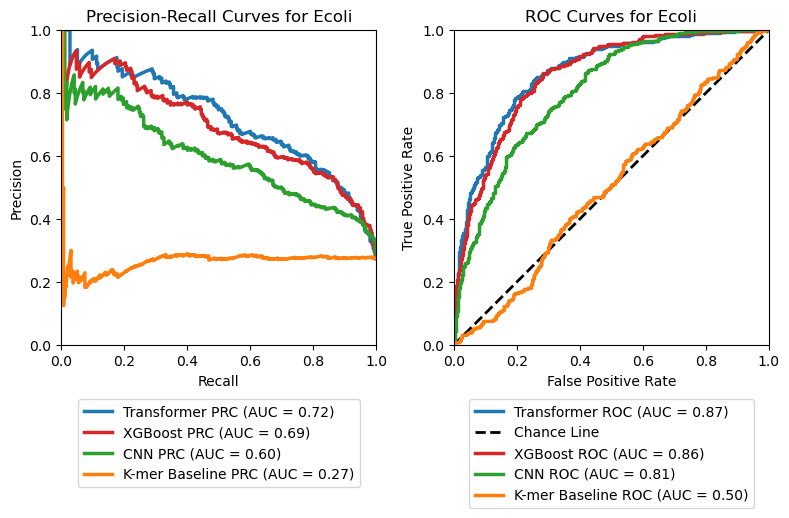

,species,model,PRC_AUC,ROC_AUC
0,ecoli,Transformer,0.718415,0.866123
1,ecoli,XGBoost,0.689486,0.858109
2,ecoli,CNN,0.597383,0.806040
3,ecoli,K-mer Baseline,0.266755,0.502519


In [3]:
# Evaluate models for a single species with standardized figure size and axis limits
def evaluate_models(models, ground_truth_file, N, species, save_as=None):
    # Use a standardized squared figure size (8x8 inches)
    plt.figure(figsize=(8, 8))

    # Subplot 1: PRC (standardized axis limits)
    plt.subplot(1, 2, 1, aspect='equal')
    plt.title(f"Precision-Recall Curves for {species.capitalize()}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.xlim(0, 1)  # Set x-axis limit for PRC
    plt.ylim(0, 1)  # Set y-axis limit for PRC

    # Subplot 2: ROC (standardized axis limits)
    plt.subplot(1, 2, 2, aspect='equal')
    plt.title(f"ROC Curves for {species.capitalize()}")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.xlim(0, 1)  # Set x-axis limit for ROC
    plt.ylim(0, 1)  # Set y-axis limit for ROC

    results = []
    plot_chance_line = True  # Initialize flag to plot "Chance Line" only once

    # Define fixed colors for each model
    model_colors = {
    'Transformer': '#1f77b4',  # Blue
    'XGBoost': '#d62728',      # Orange
    'CNN': '#2ca02c',          # Green
    'K-mer Baseline': '#ff7f0e',# Red
    'Contrast': '#9467bd'      # Purple
    }
    # Store PRC AUC for sorting
    prc_aucs = []

    # First, calculate PRC AUC for all models to sort by performance
    for model_name, prediction_file in models.items():
        predictions_df, ground_truth_df = load_data(prediction_file, ground_truth_file)
        _, _, prc_auc = calculate_prc_auc(ground_truth_df, predictions_df)
        prc_aucs.append((model_name, prc_auc, prediction_file))

    # Sort by PRC AUC (highest first)
    prc_aucs.sort(key=lambda x: x[1], reverse=True)

    # Apply specific colors from model_colors to the models
    for model_name, prc_auc, prediction_file in prc_aucs:
        predictions_df, ground_truth_df = load_data(prediction_file, ground_truth_file)

        # Get the color for the current model from the dictionary
        line_color = model_colors.get(model_name, 'gray')  # Default to gray if model name not found

        # Calculate and plot PRC
        precision, recall, _ = calculate_prc_auc(ground_truth_df, predictions_df)
        plt.subplot(1, 2, 1)
        plot_prc(precision, recall, model_name, species, line_color)

        # Calculate and plot ROC
        fpr, tpr, _ = calculate_roc_auc(ground_truth_df, predictions_df)
        plt.subplot(1, 2, 2)
        plot_roc(fpr, tpr, model_name, species, plot_chance_line, line_color)

        # After the first ROC plot, set the flag to False to avoid plotting the chance line again
        plot_chance_line = False

        # Append results, including the species name
        results.append({
            'species': species,
            'model': model_name,
            'PRC_AUC': prc_auc,
            'ROC_AUC': auc(fpr, tpr)
        })

    # Move the legend for the PRC to the bottom
    plt.subplot(1, 2, 1)
    plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.15), ncol=1)

    # Move the legend for the ROC to the bottom
    plt.subplot(1, 2, 2)
    plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.15), ncol=1)

    plt.tight_layout()

    # Save the figure in high quality if save_as is specified
    if save_as:
        plt.savefig(f'/pollard/data/projects/cpino/hackathon/figures/{save_as}', format='png', dpi=300, bbox_inches='tight')  # 300 DPI is a good high-resolution setting

    plt.show()

    # Return the results as a DataFrame, including the species name
    return pd.DataFrame(results)

# Example usage with species passed to the function
species = 'ecoli'  # vibrio, ecoli, klebsiella, phageDB, phageScope, vikecoli
models = {
    'XGBoost': f'/pollard/data/projects/cpino/hackathon/cindy/predictions/boyang_m2/{species}.predict.csv',
    'CNN': f'/pollard/data/projects/cpino/hackathon/cindy/predictions/khoa/{species}_prediction.csv',
    'K-mer Baseline': f'/pollard/data/projects/cpino/hackathon/cindy/predictions/ha/{species}_prediction.csv',
    'Transformer': f'/pollard/data/projects/cpino/hackathon/cindy/predictions/tung/{species}_predictions.csv',
    #'Contrast': f'/pollard/data/projects/cpino/hackathon/cindy/predictions/emily/vibrio_sum_prediction.csv'
}
ground_truth_file = f'/pollard/data/projects/cpino/hackathon/cindy/ground_truth/cleaned_{species}_ground_truth.csv'

# Set N value for Top-N Precision
N = 10000

# Evaluate models for the species and store results
results_df = evaluate_models(models, ground_truth_file, N, species, save_as=f'{species}_evaluation.png')

# Display results with species information included
results_df


# black background

/tmp/ipykernel_899970/1250783810.py:73: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  ax2.plot([0, 1], [0, 1], 'k--', label='Chance Line', linewidth=2, color='white')


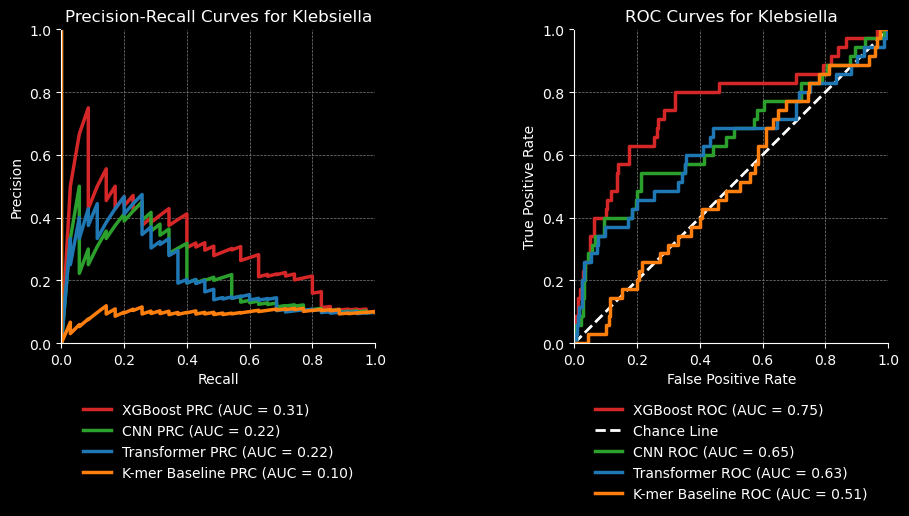

,species,model,PRC_AUC,ROC_AUC
0,klebsiella,XGBoost,0.308083,0.752795
1,klebsiella,CNN,0.218173,0.649778
2,klebsiella,Transformer,0.215250,0.628660
3,klebsiella,K-mer Baseline,0.095323,0.508341


In [13]:
# Evaluate models for a single species with standardized figure size and axis limits on a black background
def evaluate_models(models, ground_truth_file, N, species, save_as=None):
    # Set up the figure with a black background and white text, keeping the layout perfectly square
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5), facecolor='black')

    # Subplot 1: PRC (standardized axis limits)
    ax1.set_facecolor('black')
    ax1.set_title(f"Precision-Recall Curves for {species.capitalize()}", color='white')
    ax1.set_xlabel("Recall", color='white')
    ax1.set_ylabel("Precision", color='white')
    ax1.set_xlim(0, 1)  # Set x-axis limit for PRC
    ax1.set_ylim(0, 1)  # Set y-axis limit for PRC
    ax1.spines['bottom'].set_color('white')
    ax1.spines['left'].set_color('white')
    ax1.tick_params(colors='white')
    ax1.grid(True, color='gray', linestyle='--', linewidth=0.5)
    ax1.set_aspect('equal', 'box')  # Force equal aspect ratio

    # Subplot 2: ROC (standardized axis limits)
    ax2.set_facecolor('black')
    ax2.set_title(f"ROC Curves for {species.capitalize()}", color='white')
    ax2.set_xlabel("False Positive Rate", color='white')
    ax2.set_ylabel("True Positive Rate", color='white')
    ax2.set_xlim(0, 1)  # Set x-axis limit for ROC
    ax2.set_ylim(0, 1)  # Set y-axis limit for ROC
    ax2.spines['bottom'].set_color('white')
    ax2.spines['left'].set_color('white')
    ax2.tick_params(colors='white')
    ax2.grid(True, color='gray', linestyle='--', linewidth=0.5)
    ax2.set_aspect('equal', 'box')  # Force equal aspect ratio

    results = []
    plot_chance_line = True  # Initialize flag to plot "Chance Line" only once

    # Define fixed colors for each model
    model_colors = {
    'Transformer': '#1f77b4',  # Blue
    'XGBoost': '#d62728',      # Orange
    'CNN': '#2ca02c',          # Green
    'K-mer Baseline': '#ff7f0e',# Red
    'Contrast': '#9467bd'      # Purple
    }
    
    # Store PRC AUC for sorting
    prc_aucs = []

    # First, calculate PRC AUC for all models to sort by performance
    for model_name, prediction_file in models.items():
        predictions_df, ground_truth_df = load_data(prediction_file, ground_truth_file)
        _, _, prc_auc = calculate_prc_auc(ground_truth_df, predictions_df)
        prc_aucs.append((model_name, prc_auc, prediction_file))

    # Sort by PRC AUC (highest first)
    prc_aucs.sort(key=lambda x: x[1], reverse=True)

    # Apply specific colors from model_colors to the models
    for model_name, prc_auc, prediction_file in prc_aucs:
        predictions_df, ground_truth_df = load_data(prediction_file, ground_truth_file)

        # Get the color for the current model from the dictionary
        line_color = model_colors.get(model_name, 'gray')  # Default to gray if model name not found

        # Calculate and plot PRC
        precision, recall, _ = calculate_prc_auc(ground_truth_df, predictions_df)
        ax1.plot(recall, precision, label=f'{model_name} PRC (AUC = {auc(recall, precision):.2f})', color=line_color, linewidth=2.5)

        # Calculate and plot ROC
        fpr, tpr, _ = calculate_roc_auc(ground_truth_df, predictions_df)
        ax2.plot(fpr, tpr, label=f'{model_name} ROC (AUC = {auc(fpr, tpr):.2f})', color=line_color, linewidth=2.5)

        # After the first ROC plot, set the flag to False to avoid plotting the chance line again
        if plot_chance_line:
            ax2.plot([0, 1], [0, 1], 'k--', label='Chance Line', linewidth=2, color='white')
            plot_chance_line = False

        # Append results, including the species name
        results.append({
            'species': species,
            'model': model_name,
            'PRC_AUC': prc_auc,
            'ROC_AUC': auc(fpr, tpr)
        })

    # Move the legend for the PRC to the bottom
    ax1.legend(loc="upper center", bbox_to_anchor=(0.5, -0.15), ncol=1, frameon=False, facecolor='black', labelcolor='white')

    # Move the legend for the ROC to the bottom
    ax2.legend(loc="upper center", bbox_to_anchor=(0.5, -0.15), ncol=1, frameon=False, facecolor='black', labelcolor='white')

    # Adjust layout to minimize padding and ensure the figure is square
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.3)  # Adjust space between the subplots

    # Save the figure in high quality if save_as is specified
    if save_as:
        plt.savefig(f'/pollard/data/projects/cpino/hackathon/figures/{save_as}', format='png', dpi=300, bbox_inches='tight', facecolor='black')

    plt.show()

    # Return the results as a DataFrame, including the species name
    return pd.DataFrame(results)

# Example usage with species passed to the function
species = 'klebsiella'  # vibrio, ecoli, klebsiella, phageDB, phageScope, vikecoli
models = {
    'XGBoost': f'/pollard/data/projects/cpino/hackathon/cindy/predictions/boyang_m2/{species}.predict.csv',
    'CNN': f'/pollard/data/projects/cpino/hackathon/cindy/predictions/khoa/{species}_prediction.csv',
    'K-mer Baseline': f'/pollard/data/projects/cpino/hackathon/cindy/predictions/ha/{species}_prediction.csv',
    'Transformer': f'/pollard/data/projects/cpino/hackathon/cindy/predictions/tung/{species}_predictions.csv',
    #'Contrast': f'/pollard/data/projects/cpino/hackathon/cindy/predictions/emily/vibrio_sum_prediction.csv'
}
ground_truth_file = f'/pollard/data/projects/cpino/hackathon/cindy/ground_truth/cleaned_{species}_ground_truth.csv'

# Set N value for Top-N Precision
N = 10000

# Evaluate models for the species and store results
results_df = evaluate_models(models, ground_truth_file, N, species, save_as=f'{species}_evaluation_black_background_square.png')

# Display results with species information included
results_df
